In [2]:
########################################
#LIBRARIES

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as dde
import matplotlib.pyplot as plt
import json
import sklearn
import os

########################################
#PARAMETERS
nTimeSteps = 60; #at 60 Hz
epochs = 100
minibatch_size= 50
hiddenlayers = [100]
input_size = 15
output_size = 3*nTimeSteps
testsize = 0.2
use_case = 'varstart'
learning_rate = 0.001
LRdecay = 0.7
model_file_path = '../Trained_Models/'
sample_file_path = f'../Data/Samples/data_varstart_{nTimeSteps}tsteps1339/'
simulation_file_path = '../Data/Simulations/pm_target.sim'
objective_file_path = f'../Data/Objectives/pm_target.obj'
# set log level
dde.set_log_level(dde.LogLevel.off)
print(os.listdir(sample_file_path))

dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)

['data_1.json', 'data_16.json', 'data_17.json', 'vari.out', 'data_0.json', 'data_10.json', 'data_7.json', 'data_6.json', 'data_11.json', 'Description.json', 'data_9.json', 'data_12.json', 'data_5.json', 'data_4.json', 'data_8.json', 'data_13.json', 'data_3.json', 'data_18.json', 'data_14.json', 'data_15.json', 'data_2.json', 'data_19.json']


In [10]:
#########################################
#LOAD TRAINING SAMPLES
number_of_files = len(os.listdir(sample_file_path))-3
with open(sample_file_path + f'data_0.json') as json_file:
    data = json.load(json_file)
    filesize = len(data['q_target'])
samplenum = filesize*number_of_files
input = np.zeros((samplenum, input_size))

p = np.zeros((dyn.nParameters*nTimeSteps, samplenum))
input = np.zeros((samplenum, input_size))

for filenum in range(number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q_target'])
        for i, p_i in enumerate(data['p']):
            p[:, filenum*filesize+i] = np.array(p_i)
        for i, q_target_i in enumerate(data['q_target']):
            input[filenum*filesize+i, 0:3] = np.array(q_target_i)
        for i, q_i in enumerate(data['q']):
            input[filenum*filesize+i, 3:6] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input[filenum*filesize+i, 6:9] = np.array(qdot_i)
        for i, qddot_i in enumerate(data['qddot']):
            input[filenum*filesize+i, 9:12] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input[filenum*filesize+i, 12:15] = np.array(p_now_i)
p = p.transpose()


#Remove zeros
p_data = p[~(input == 0).all(1)]
data = input[~(input == 0).all(1)]
print(data.shape)
print(p_data.shape)

#normalize qddot
'''
def minmaxscale(input, extrema):
    if extrema == None:
        maximas= []
        minimas= []
        for i in range(len(input[0, :])):
            maximas.append(np.max(input[:,i]))
            minimas.append(np.min(input[:,i]))
        max = np.max(maximas)
        min = np.min(minimas)
        extrema = np.max([max, np.linalg.norm(min)])
        scaled = (input+extrema)/(2*extrema)
        return scaled, extrema
    else:
        scaled = (input+extrema)/(2*extrema)
        return scaled
print(input[0:4, 9:12])
data[:, 6:9], extr_qdot = minmaxscale(data[:, 6:9], None)
data[:, 9:12], extr_qddot = minmaxscale(data[:, 9:12], None)
p_data, extr_p = minmaxscale(p_data, None)
print(data[0:4, 9:12])
'''

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
input, input_test, p, p_test = train_test_split(data, p_data, test_size = testsize)

input = torch.tensor(input).float()
p = torch.tensor(p).float()
samplenum = len(input[:,0])

input_test = torch.tensor(input_test).float()
p_test = torch.tensor(p_test).float()
samplenum_test = len(input_test[:,0])

print(f'Shape of input: {input.shape}')
print(f'Shape of p: {p.shape}')
print(f'Shape of input_test: {input_test.shape}')
print(f'Shape of p_test: {p_test.shape}')

(19000, 15)
(19000, 180)
Shape of input: torch.Size([15200, 15])
Shape of p: torch.Size([15200, 180])
Shape of input_test: torch.Size([3800, 15])
Shape of p_test: torch.Size([3800, 180])


In [6]:
print(input[5,:])

tensor([ 0.5510,  0.3966,  0.1735,  0.6850,  0.1113,  0.2941,  0.0965,  0.0257,
        -0.1893, -0.1852,  0.2284,  3.9589,  0.6764,  0.5783,  0.4783])


In [47]:
#########################################
#LOAD TEST SAMPLES
'''
number_of_files_test = len(os.listdir(sample_file_path + 'data_test/'))
samplenum_test = 1000*number_of_files_test

p_test = np.zeros((3*nTimeSteps, samplenum_test))
input_test = np.zeros((samplenum_test, input_size))

for filenum in range(number_of_files_test):
    with open(sample_file_path + f'data_test/data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q_target'])
        for i, p_i in enumerate(data['p']):
            p_test[:, filenum*filesize+i] = np.array(p_i)
        for i, q_target_i in enumerate(data['q_target']):
            input_test[filenum*filesize+i, 0:3] = np.array(q_target_i)
        for i, q_i in enumerate(data['q']):
            input_test[filenum*filesize+i, 3:6] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input_test[filenum*filesize+i, 6:9] = np.array(qdot_i)
        #for i, qddot_i in enumerate(data['qddot']):
         #   input_test[filenum*filesize+i, 9:12] = np.array(qddot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input_test[filenum*filesize+i, 12:15] = np.array(p_now_i)
p_test = p_test.transpose()

print(f'Shape of input_test: {input_test.shape}')
print(f'Shape of p_test: {p_test.shape}')
#Remove zeros
p_test = p_test[~(input_test == 0).all(1)]
input_test = input_test[~(input_test == 0).all(1)]
print(input_test.shape)
print(p_test.shape)

input_test = torch.tensor(input_test).float()
p_test = torch.tensor(p_test).float()
samplenum_test = len(input_test[:,0])
'''

Shape of input_test: (1000, 15)
Shape of p_test: (1000, 180)
(1000, 15)
(1000, 180)


epoch:   0/100    LR:   0.001000  loss: 0.00069375
epoch:  10/100    LR:   0.001000  loss: 0.00002169
epoch:  20/100    LR:   0.000700  loss: 0.00000995
epoch:  30/100    LR:   0.000490  loss: 0.00000563
epoch:  40/100    LR:   0.000490  loss: 0.00000406
epoch:  50/100    LR:   0.000343  loss: 0.00000306
epoch:  60/100    LR:   0.000240  loss: 0.00000253
epoch:  70/100    LR:   0.000240  loss: 0.00000218
epoch:  80/100    LR:   0.000168  loss: 0.00000212
epoch:  90/100    LR:   0.000118  loss: 0.00000203
epoch:  99 final loss: 0.00000207

Training completed. Total duration: 7.452 min


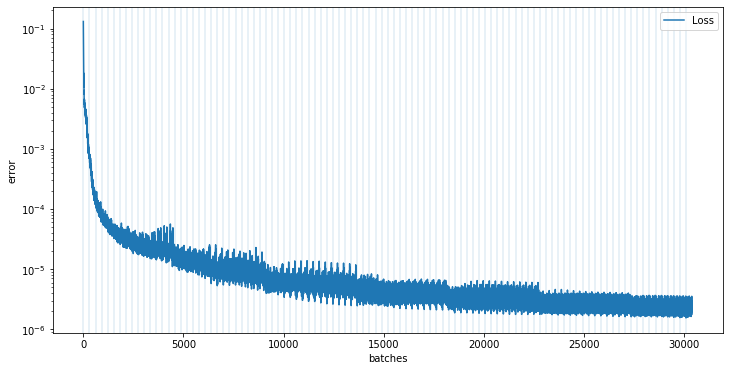

In [11]:
################################
#BUILD MODEL
class PassiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(PassiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, hiddenlayers[0])
        self.H1 = nn.Linear(hiddenlayers[0], 3*nTimeSteps)
        self.L_out = nn.Linear(3*nTimeSteps, 3*nTimeSteps)
        self.Relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p=0.5)
    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        x = self.Relu(x)
        x = self.L_out(x)
        return x

model = PassiveLearn(input_size, output_size)

criterion = nn.SmoothL1Loss()  # RMSE = np.sqrt(MSE)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=LRdecay, last_epoch=-1)

################################################
#TRAIN THE MODEL

torch.autograd.set_detect_anomaly(True)

start_time = time.time()
weight_c1 = 1 # p error condition
batch = np.floor(samplenum/minibatch_size).astype(int)
losses= []
p_smoothness_errors = []
basic_errors = [] #y_end_ and p_start error
for e in range(epochs):
    for b in range(batch):
        loss_batch = 0
        smoothness_error_batch = 0
        input_i = input[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_i = p[b*minibatch_size:b*minibatch_size+minibatch_size,:]
        p_pred = model(input_i)
        #error claculation
        loss_batch = weight_c1* criterion(p_pred, p_i)
        losses.append(loss_batch)
        optimizer.zero_grad()
        #Back Prop
        loss_batch.backward()
        optimizer.step()
    scheduler.step()
    LR= scheduler.get_lr()
    if e%(epochs/10) == 0:
        print(f'epoch: {e:3}/{epochs}    LR: {LR[0]:10.6f}  loss: {loss_batch.item():10.8f}')

print(f'epoch: {e:3} final loss: {loss_batch.item():10.8f}') # print the last line
print(f'\nTraining completed. Total duration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

##################################################
#Plot loss for each batch after each epoch
epoch_lines = np.arange(0, epochs*batch, batch)
plt.figure(figsize = [12,6])
loss = plt.plot(losses, label = 'Loss')
plt.legend()
plt.yscale('log')
plt.ylabel('error')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.show()

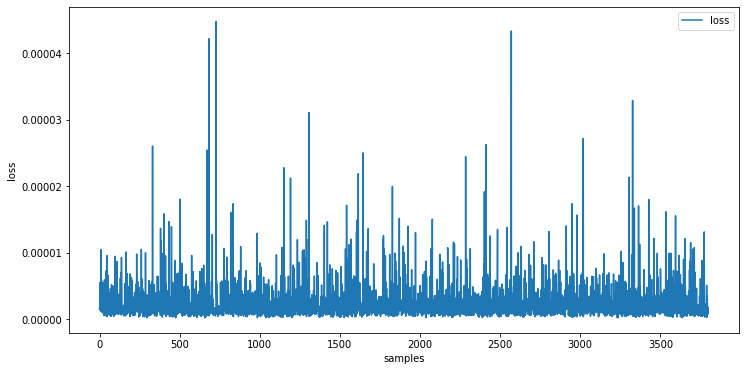

2.5263623e-06


In [12]:
####################################################
#Test the data
samplenum_test = len(input_test[:,0])
losses_test= []
with torch.no_grad():
    for i in range(samplenum_test):
        p_val = model(input_test[i, :])
        loss_test = criterion(p_val,p_test[i,:])
        losses_test.append(loss_test.clone().numpy())
#plot test errors
plt.figure(figsize = [12,6])
loss_test_plot = plt.plot(losses_test, label = 'loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('samples')
plt.show()
tot_error = np.mean(losses_test)
print(tot_error)

## PLOTS

In [13]:
#relative error
rel_errors_norm = []
with torch.no_grad():
    for i in range(samplenum_test):
            p_val = model(input_test[i, :])
            p_truth = p_test[i,:]
            rel_error = np.linalg.norm((p_val - p_truth)/p_truth)
            rel_errors_norm.append(rel_error)

rel_errors_sum = torch.zeros(3*nTimeSteps)
abs_errors_sum = torch.zeros(3*nTimeSteps)
with torch.no_grad():
    for i in range(samplenum_test):
            p_val = model(input_test[i, :])
            p_truth = p_test[i,:]
            rel_error = (p_val - p_truth)/p_truth
            abs_error = np.abs(p_val - p_truth)
            rel_errors_sum = rel_errors_sum + rel_error
            abs_errors_sum = abs_errors_sum + abs_error
x_err_rel = rel_errors_sum[0::3]/(samplenum_test)
y_err_rel = rel_errors_sum[1::3]/(samplenum_test)
z_err_rel = rel_errors_sum[2::3]/(samplenum_test)

x_err = abs_errors_sum[0::3]/(samplenum_test)
y_err = abs_errors_sum[1::3]/(samplenum_test)
z_err = abs_errors_sum[2::3]/(samplenum_test)

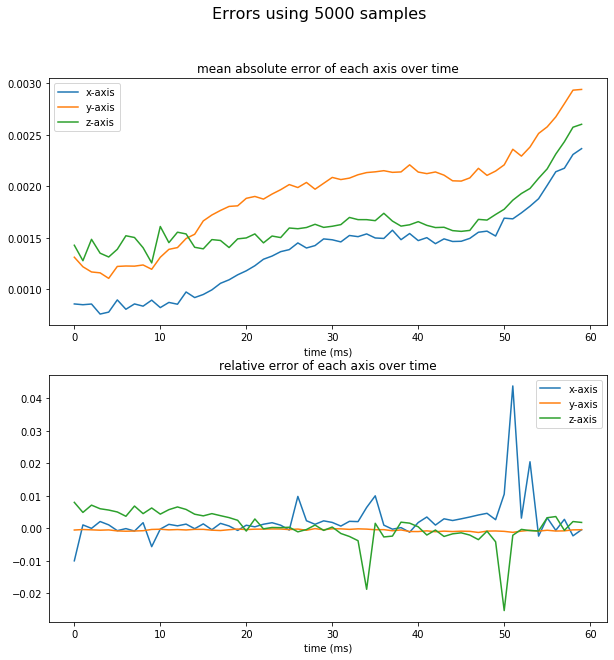

In [14]:
plt.figure(figsize = [10,10])
plt.suptitle('Errors using 5000 samples', fontsize=16)

plt.subplot(2, 1, 2)
plt.plot(x_err_rel, label = 'x-axis')
plt.plot(y_err_rel, label = 'y-axis')
plt.plot(z_err_rel, label = 'z-axis')
plt.xlabel('time (ms)')
plt.title('relative error of each axis over time')
plt.legend()

plt.subplot(2, 1, 1)
plt.plot(x_err, label = 'x-axis')
plt.plot(y_err, label = 'y-axis')
plt.plot(z_err, label = 'z-axis')
plt.xlabel('time (ms)')
plt.title('mean absolute error of each axis over time')
plt.legend()
plt.show()

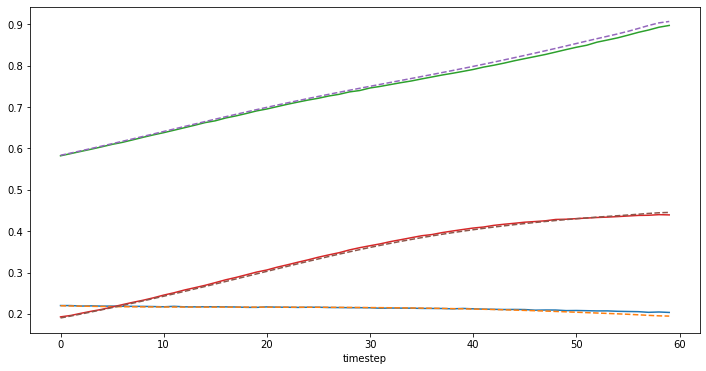

In [15]:
#x, y and z plot
randomsample = 98
with torch.no_grad():
        p_val = model(input_test[randomsample, :])
        p_truth = p_test[randomsample,:]
        x_val = p_val[0::3]
        y_val = p_val[1::3]
        z_val = p_val[2::3]
        x_truth = p_truth[0::3]
        y_truth = p_truth[1::3]
        z_truth = p_truth[2::3]
            

plt.figure(figsize = [12,6])
plt.plot(x_val)
plt.plot(x_truth, '--')
plt.plot(y_val)
plt.plot(z_val)
plt.plot(y_truth, '--')
plt.plot(z_truth, '--')

plt.xlabel('timestep')
plt.show()

In [16]:
#####################################################
#SAVE MODEL
timestr = time.strftime("%m%d")
#Save entire Model
torch.save(model, model_file_path + 'Model_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
torch.save(model, model_file_path + 'Model_passive_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')

#Save parameters of Model
torch.save(model.state_dict(), model_file_path + 'state_dict/Trained_Model_statedict_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
torch.save(model.state_dict(), model_file_path + 'state_dict/Model_statedict_passive_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')

#Convert to Torch Script and save for CPP application
input_example = input[4, :]
traced_script_module = torch.jit.trace(model, input_example)

# Test the torch script
#test_input = torch.tensor([0, 2, 0.5])
#original = model(test_input)
#output_example = traced_script_module(test_input)

traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_passive_' + use_case + f'_{nTimeSteps}tsteps_latest.pt')
traced_script_module.save(model_file_path + 'Serialized_Models/Serialized_model_passive_' + use_case + f'_{nTimeSteps}tsteps_{samplenum}s_{epochs}e_{LRdecay}lr_' + timestr + '.pt')
print('Model saved')

Model saved


In [35]:
#####################################################
# !!!!!!!!!!!!!!!NOT READY YET!!!!!!!!!!!!!!
#TEST THE MODEL

# Generate simulation
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(0,nTimeSteps):
	p_init[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init)
r = dyn.r(state_init, p_init)
dr = dyn.dr_dp(state_init, p_init)
dq = dyn.dq_dp(state_init, p_init)

#Load objective
obj = dde.InverseObjective(dyn)

#obj.loadFile(objective_file_path)
data = json.load(open(objective_file_path))
data['objectives']['pmTargetPositions'][0]['targetPos'] = ([[0.5],[0.5],[0.5]])
obj.loadJson(data)

y_target_test_= torch.tensor([0.5, 0.5, 0.5])
p_ = model(y_target_test_)
p_ = p_.detach().numpy()
newton = dde.Newton()
p_truth_ = newton.minimize(obj, p_init)
y_target_ = y_target_test_.detach().numpy()

yTraj_test_ = dyn.q(p_)
yTraj_truth_ = dyn.q(p_truth_)

print('TEST OF THE MODEL')
print(f'\ntest for y_target:\n {y_target_test_}')
print(f'\nevaluated y_end:\n {yTraj_test_.q[-3:]}')
print(f'\nsimulated traj_opt y_end with p_truth:\n {yTraj_truth_.q[-3:]}')
print(f'\ndifference of y_end:\n {np.sum(yTraj_test_.q[-3:]-y_target_)}')
print(f'\nlast 6 entries of p predicted:\n {p_[-6:].transpose()}')
print(f'\nlast 6 entries of p from traj_opt:\n {p_truth_[-6:].transpose()}')

TEST OF THE MODEL

test for y_target:
 tensor([0.5000, 0.5000, 0.5000])

evaluated y_end:
 [0.49432393 0.49335369 0.4951183 ]

simulated traj_opt y_end with p_truth:
 [0.49560763 0.49293486 0.49560763]

difference of y_end:
 -0.017204084384135065

last 6 entries of p predicted:
 [0.47749302 1.2182992  0.47810224 0.4774424  1.2185354  0.47826165]

last 6 entries of p from traj_opt:
 [0.47875592 1.21774452 0.47875592 0.478775   1.21785194 0.478775  ]
